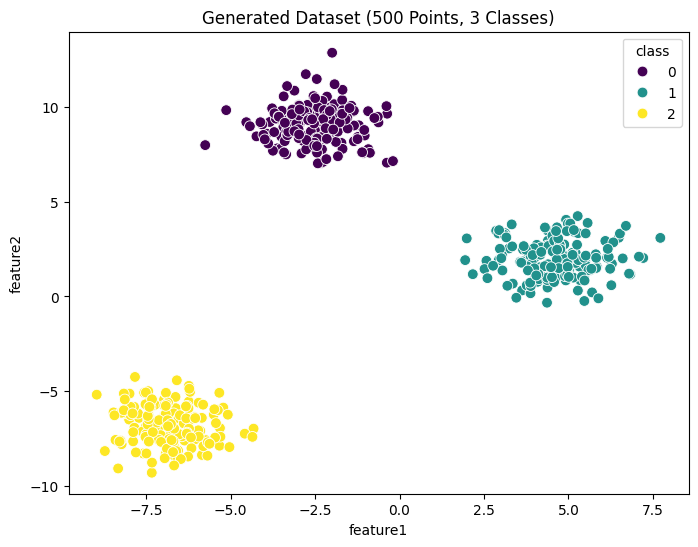

Epoch 0, Loss: 0.4871
Epoch 1000, Loss: 0.1217
Epoch 2000, Loss: 0.1216
Epoch 3000, Loss: 0.1216
Epoch 4000, Loss: 0.1216
Epoch 5000, Loss: 0.1216
Epoch 6000, Loss: 0.1216
Epoch 7000, Loss: 0.1216
Epoch 8000, Loss: 0.1216
Epoch 9000, Loss: 0.1216
Epoch 10000, Loss: 0.1216
Epoch 11000, Loss: 0.1216
Epoch 12000, Loss: 0.1216
Epoch 13000, Loss: 0.1216
Epoch 14000, Loss: 0.1216
Epoch 15000, Loss: 0.1216
Epoch 16000, Loss: 0.1216
Epoch 17000, Loss: 0.1216
Epoch 18000, Loss: 0.1216
Epoch 19000, Loss: 0.1216


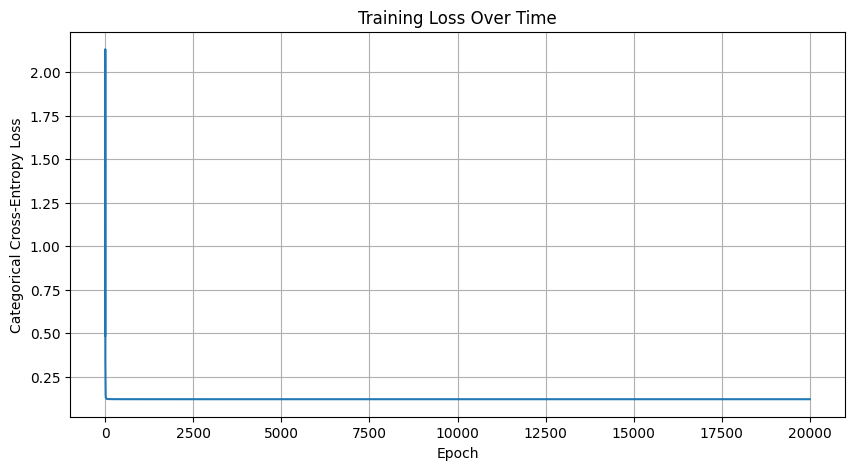

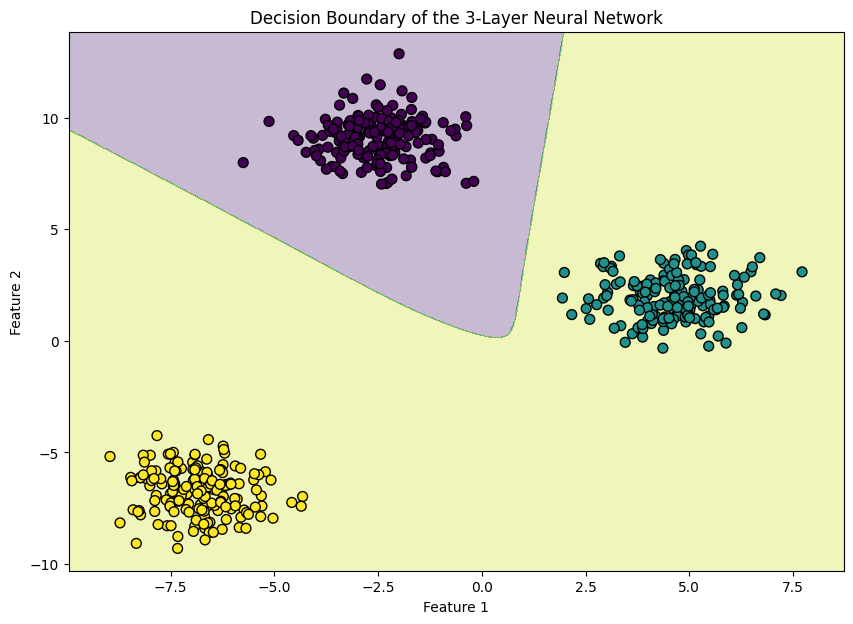

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder

# Set a seed for reproducibility
np.random.seed(42)

# --- 1. Data Generation and Preparation ---

# Generate 500 data points with 3 classes (centers)
X, y_raw = make_blobs(n_samples=500, centers=3, n_features=2, 
                      cluster_std=1.0, random_state=42)

# One-Hot Encode the labels (Y)
# The shape of y_raw is (500,). We need it to be (500, 1) for the encoder.
y_reshaped = y_raw.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(y_reshaped)

# Visualize the generated data
df = pd.DataFrame(X, columns=['feature1', 'feature2'])
df['class'] = y_raw
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='feature1', y='feature2', hue='class', palette='viridis', s=60)
plt.title('Generated Dataset (500 Points, 3 Classes)')
plt.show()

# --- 2. Extending the Neural Network to 3 Layers ---

class NeuralNetwork:
    def __init__(self, X, Y):
        # Define the architecture
        self.inputLayerNeurons = X.shape[1]    # Number of features (2)
        self.hiddenLayer1Neurons = 25          # Neurons in first hidden layer
        self.hiddenLayer2Neurons = 25          # Neurons in second hidden layer
        self.outputLayerNeurons = Y.shape[1]   # Number of classes (3)
        
        self.learning_rate = 0.01
        
        # Initialize weights randomly with a small scale
        # Weights from Input to Hidden Layer 1
        self.W_IH1 = np.random.randn(self.inputLayerNeurons, self.hiddenLayer1Neurons) * 0.1
        # Weights from Hidden Layer 1 to Hidden Layer 2
        self.W_H1H2 = np.random.randn(self.hiddenLayer1Neurons, self.hiddenLayer2Neurons) * 0.1
        # Weights from Hidden Layer 2 to Output Layer
        self.W_H2O = np.random.randn(self.hiddenLayer2Neurons, self.outputLayerNeurons) * 0.1
        
    def sigmoid(self, x, der=False):
        if der:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        # Subtract max for numerical stability
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
        
    def feedForward(self, X):
        # Input -> Hidden Layer 1
        hidden1_input = np.dot(X, self.W_IH1)
        self.hidden1_output = self.sigmoid(hidden1_input)
        
        # Hidden Layer 1 -> Hidden Layer 2
        hidden2_input = np.dot(self.hidden1_output, self.W_H1H2)
        self.hidden2_output = self.sigmoid(hidden2_input)
        
        # Hidden Layer 2 -> Output Layer
        output_input = np.dot(self.hidden2_output, self.W_H2O)
        pred = self.softmax(output_input) # Use softmax for multi-class output
        return pred
        
    def backPropagation(self, X, Y, pred):
        # --- Stage 1: Output Layer ---
        # The derivative of cross-entropy loss with softmax is simply (prediction - actual)
        output_error = pred - Y
        
        # --- Stage 2: Hidden Layer 2 ---
        hidden2_error = output_error.dot(self.W_H2O.T)
        hidden2_delta = hidden2_error * self.sigmoid(self.hidden2_output, der=True)

        # --- Stage 3: Hidden Layer 1 ---
        hidden1_error = hidden2_delta.dot(self.W_H1H2.T)
        hidden1_delta = hidden1_error * self.sigmoid(self.hidden1_output, der=True)
        
        # --- Update Weights ---
        # Note: We are not multiplying by learning_rate here as it's cleaner to do it at the end.
        dW_H2O = self.hidden2_output.T.dot(output_error)
        dW_H1H2 = self.hidden1_output.T.dot(hidden2_delta)
        dW_IH1 = X.T.dot(hidden1_delta)
        
        self.W_H2O -= self.learning_rate * dW_H2O
        self.W_H1H2 -= self.learning_rate * dW_H1H2
        self.W_IH1 -= self.learning_rate * dW_IH1
        
    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)
        
    def predict(self, X):
        # Run feedforward and return the class with the highest probability
        probabilities = self.feedForward(X)
        return np.argmax(probabilities, axis=1)

# --- 3. Training the Network ---

NN = NeuralNetwork(X, Y)
loss_history = []

epochs = 20000

for i in range(epochs):
    NN.train(X, Y)
    
    # Calculate Cross-Entropy Loss
    # Add a small epsilon to prevent log(0)
    epsilon = 1e-10 
    predictions = NN.feedForward(X)
    loss = -np.mean(Y * np.log(predictions + epsilon))
    loss_history.append(loss)
    
    if i % 1000 == 0:
        print(f'Epoch {i}, Loss: {loss:.4f}')

# --- 4. Visualizing Results ---

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross-Entropy Loss')
plt.grid(True)
plt.show()

# Function to plot the decision boundary
def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Predict the function value for the whole grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k', cmap='viridis')
    plt.title("Decision Boundary of the 3-Layer Neural Network")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Plot the final decision boundary
plot_decision_boundary(X, y_raw, NN)